# Практикум по стохастическому анализу. Часть №1

Выполнил \
Пилюшенок Артур \
студент 415 группы ВМК МГУ

In [452]:
import numpy as np                              # matrix calculations
from matplotlib import pyplot as plt            # plotting

# empirical cumulative distribution function, distributions and quantiles
from scipy.stats import ecdf, norm, poisson, f, probplot, chi2

Префиксы
- $\texttt{rand}$ - датчики (генераторы) распределений
- $\texttt{gen}$ - датчики (генераторы) распределений, производных от датчиков $\texttt{rand}$ / генераторы траекторий
- $\texttt{test}$ - реализация критериев для проверки гипотез

## Задание 1

### Условие
1. Реализовать генератор схемы Бернулли с заданной вероятностью успеха $p$. На
основе генератора схемы Бернулли построить датчик биномиального распределения.

2. Реализовать генератор геометрического распределения; проверить для данного
распределения свойство отсутствия памяти.

3. Промоделировать игру в орлянку: бесконечную последовательность независимых испытаний Бернулли 
с бросанием “правильной” (честной, $p=0.5$) монеты. Величина “выигрыша” $S_n$ определяется как сумма 
по $n$ испытаниям значений 1 и −1 в зависимости от выпавшей стороны монеты. Проиллюстрировать в виде
ломаной поведение нормированной суммы $Y(i)=\frac{S_i}{\sqrt{n}}$ как функцию от номера испытания $i$ 
для отдельно взятой траектории. Дать теоретическую оценку для значения $Y(n)$ при $n\to\infty$.

### Генераторы схемы Бернулли и биномиального распределения

Воспользуемся методом обращения функции распределения. Он основан на следующем утверждении.

__Утвержденине__ Пусть функция распределения $F(\cdot)$ имеет обратную $F^{-1}(\cdot)$. Положим $\nu\sim\mathrm{U}[0,1]$. Тогда функцией распределения случайной величины $\xi=F^{-1}(\nu)$ является $F(\cdot)$.

Доказательство.
$$
F_\xi(x) = \mathbb{P}(\xi < x) = \mathbb{P}(F^{-1}(\nu) < x) = \mathbb{P}(\nu < F(x)) = F(x).
$$

Мы будем использовать генератор многомерной выборки, отвечающей схеме Бернулли, реализованный при помощи метода $\texttt{numpy.random.rand}$. \
Это позволит нам генерировать несколько двумерных выборок одновременно.

In [ ]:
def rand_bern(p, *args):
    '''
    Bernoulli scheme generator
    returns tensor with given shapes
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if p > 1 or p < 0:
        raise ValueError("Probability of success must be in range [0,1].")
    if not args:
        return int(np.random.rand() < p)
    return (np.random.rand(*args) < p).astype(int)

В качестве примера работы генератора схемы Бернулли изобразим гистограмму для выборки размера $N = 10^7$. \
Вероятность единицы должна быть близка к параметру $p$ генератора.

In [97]:
p = 0.54321
N = 10**7
sample_bern = rand_bern(p, N)

Параметр p=0.54321.
Вероятность единицы в выборке: 0.54334.


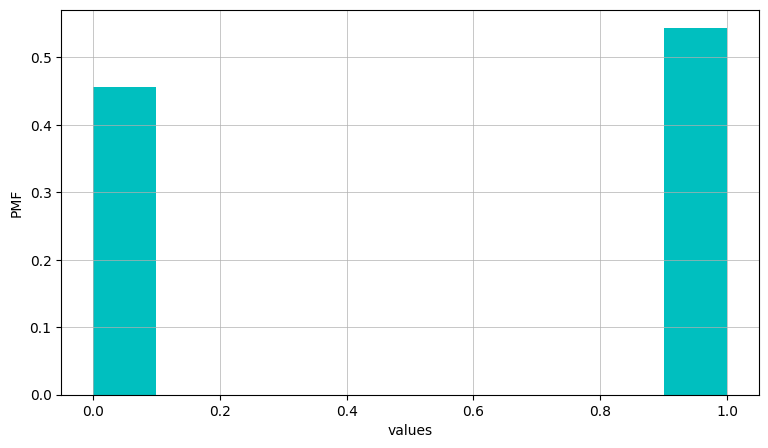

In [98]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

counts, bins = np.histogram(sample_bern)
ax.stairs(counts / N, bins, fill=True, color='c')
print('Параметр p={:1.5f}.\nВероятность единицы в выборке: {:1.5f}.'.format(p, counts[-1] / N))

plt.ylabel('PMF')
plt.xlabel('values')
plt.show()

Далее воспользуемся $\texttt{rand\_bern}$ для реализации генератора $\mathrm{Bin}(n,p)$.

Здесь можно сгенерировать одним запуском $n$ выборок схемы Бернулли, но при больших $n$ память легко может переполниться. \
Например, двумерная выборка размерности $100$ на $100$ при $n=10^7$ переполняет свободную память компьютера, хотя и состоит всего из $10^5$ значений.

Чтобы избежать переполнения памяти при больших $n$, можно запускать $\texttt{rand\_bin}$ в цикле.

In [298]:
def rand_bin(n, p, *args):
    '''
    Binomial distribution generator
    returns tensor with given shapes
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, (int, np.integer)) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return rand_bern(p, n, *args).sum(axis=0)

Отметим, что генерация одним запуском в разы эффективнее генерации в цикле.
<!-- Приведем листинг эффективной по времени генерации, но приводящей к переполнению.
```python
def rand_bin(n, p, *args):
    if not isinstance(n, int) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return rand_bern(p, n, *args).sum(axis=0)
``` -->
Данной реализацией можно пользоваться при произведении $n$ на все результирующие размерности меньшем $10^8$ (или меньшем количества свободных байт в памяти компьютера). Для генерации выборок большого размера будем последовательно вызывать генератор.

Продемонстрируем работу датчика биномиального распределения: проверим выполнение ЦПТ.

In [299]:
n = 66
p = 0.54321
N = 10**6

sample_bin = rand_bin(n, p, N)

mu = n*p
sigma = np.sqrt(n*p*(1-p))
print('Teoretical mu={:1.4}, sigma^2={:1.4}'.format(mu, sigma))
print('Numerical mu={:1.4}, sigma^2={:1.4}'.format(sample_bin.mean(), sample_bin.std()))

Teoretical mu=35.85, sigma=4.047
Numerical mu=35.86, sigma=4.046


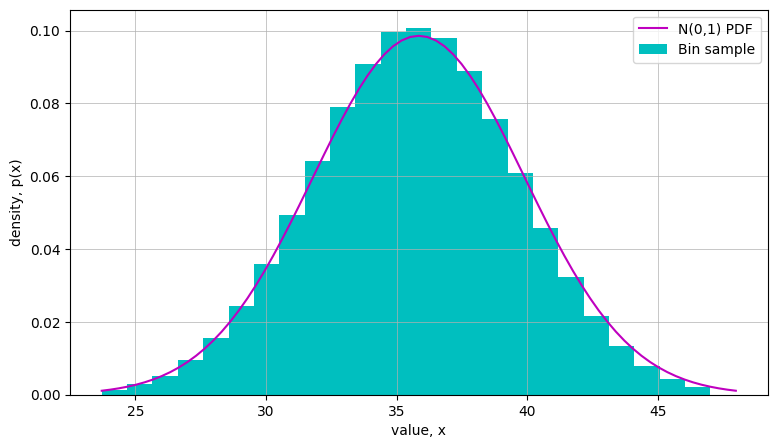

In [300]:
n_bins = 25
grid = np.linspace(mu - 3*sigma, mu + 3*sigma, n_bins*3)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_bin, bins=n_bins, range=(mu - 3*sigma, mu + 3*sigma), color='c', density=True)
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), color='m')

plt.ylabel('density, p(x)')
plt.xlabel('value, x')
plt.legend(['N(0,1) PDF', 'Bin sample'])
plt.show()

### Генератор геометрического распределения


Всюду далее считаем, что геометрическое распределение - это распределение числа неуспехов до первого успеха 
в схеме Бернулли с неограниченным числом испытаний.

Обозначим
$$
\xi \sim \operatorname{Geom}(p),\quad \nu \sim \operatorname{U}[0,1].\\
\mathbb{P}(\xi = n) = p(1-p)^n,\quad \sum_{k=0}^{n} p(1-p)^k = 1 - (1-p)^{n+1} = s_{n+1}.
$$
Пользуясь генератором равномерного распределения, реализуем генератор геометрического распределения, исходя из следующих соображений:
$$
\mathbb{P}(\xi = n) = \mathbb{P}(s_{n}<\nu\leqslant s_{n+1}) = \mathbb{P}((1-p)^{n+1} \leqslant 1-\nu < (1-p)^{n}).
$$
$$
\Longrightarrow~ \boxed{\mathbb{P}(\xi = n) = \mathbb{P}\left( n < \dfrac{\ln{(1-\nu)}}{\ln(1-p)} \leqslant n+1  \right).}
$$
Отметим, что $(1-\nu) \sim \operatorname{U}[0,1]$.

Таким образом, будем моделировать случайную величину
$$
\eta = \bigg\lfloor \dfrac{\ln\nu}{\ln(1-p)} \bigg\rfloor.
$$

Можно доказать, что $\frac{\ln\nu}{\ln(1-p)}\sim\mathrm{Exp}(-\ln\frac{1}{1-p})$:
$$
\mathbb{P}\left(\frac{\ln\nu}{\ln(1-p)}<x\right) = \mathbb{P}(\nu < e^{\ln(1-p)x}) = 1 - e^{\ln(1-p)x}.
$$

In [102]:
def rand_geom(p, *args):
    '''
    Geometrical distribution generator
    returns tensor with given shapes
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if p > 1 or p < 0:
        raise ValueError("Probability of success must be in range [0,1].")
    return np.floor(np.log(np.random.rand(*args)) / np.log(1-p)).astype(int)

Покажем, что данное распределение обладает свойством отсутствия памяти:
$$
\mathbb{P}(\xi > m+n ~\vert~ \xi \geqslant m) = \mathbb{P}(\xi > n),~ \forall m,n \in \{0,1,2\dots\}
$$

Для этого построим две гистограммы для двух выборок (отвечающих левой и правой частям соответственно). \
Сдвинутые графики должны совпасть.

In [409]:
p = 0.2
N = 10**7
m = 7

(2098359,)

In [ ]:
sample_geom_1 = rand_geom(p, N)
sample_geom_2 = rand_geom(p, N)
sample_geom_2 = sample_geom_2[sample_geom_2 >= m]
sample_geom_2.shape

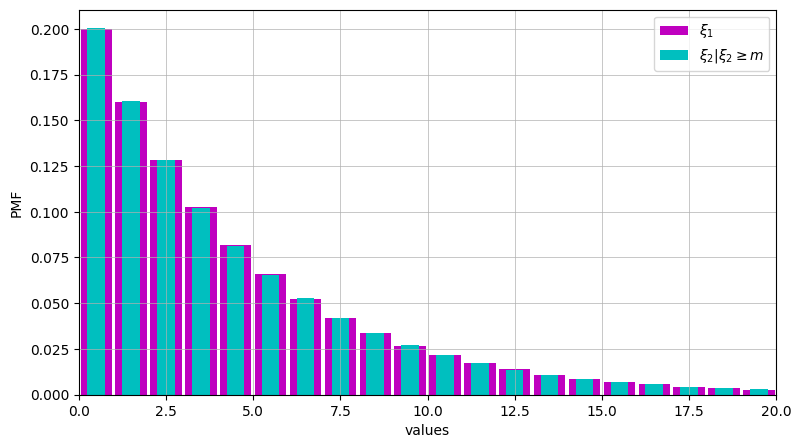

In [ ]:
n_bins = 30
bins = np.arange(0, n_bins)

alpha = 0.01
xlim = np.floor(np.log(alpha) / np.log(1-p))

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

ax.hist(sample_geom_1, bins,
    density=True,
    rwidth=0.9,
    color='m',
    label='$\\xi_1$'
)
ax.hist(sample_geom_2 - m, bins,
    density=True,
    rwidth=0.5,
    color='c',
    label='$\\xi_2|\\xi_2\\geq m$'
)

plt.ylabel('PMF')
plt.xlabel('values')
plt.legend()
plt.show()

### Игра в орлянку

Рассмотрим
$$
S_n = \sum^{n}_{i=1} \eta_i,\quad \eta_i = 2\xi_i-1,\quad \xi_i \sim \operatorname{Be}(p) \text{ --- i.i.d.r.v.}\\
Y_n = \dfrac{S_n}{\sqrt{n}}.
$$

Зафиксируем $p=1/2$. В таком случае
$$
\mathbb{E}\nu_i \equiv \mu = 2p-1 = 0.\\
\mathbb{D}\nu_i \equiv \sigma^2 = 4p(1-p) = 1.
$$

Воспользуемся ЦПТ.
$$
\mathbb{P}\left( \dfrac{S_n - n\mu}{\sigma\sqrt{n}} < x \right) \to \Phi(x)=\dfrac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-y^2/2}dy,~n\to\infty.
$$

Заметим, что нормированная случайная величина внутри функции распределения в левой части выражения совпадает с $Y_n$. \
Также отметим, что третий абсолютный момент $\mathbb{E}|\eta_i|^3=1$, ведь $|\eta_i|\equiv1$. \
В таком случае можем воспользоваться неравенством Берри-Эссеена, где $c_0\in(0.4,0.5)$.
$$
\sup_{x\in\mathbb{R}}\left| \mathbb{P}\left( \dfrac{S_n}{\sqrt{n}} < x \right) - \Phi(x) \right| < \dfrac{c_0}{n^{3/2}}.
$$

Получили оценку скорости сходимости в ЦПТ. \
Нас также интересует оценка значений $Y_n(\omega)$.

Уже показали, что
$$
Y_n \stackrel{d}{\to} \xi\sim\mathrm{N}(0,1).
$$
Следовательно, по мере увеличения числа элементов $n$ нормированная сумма $Y(n)$ будет распределена нормально.

Также продемонстрируем поведение траектории $Y_i = \frac{S_i}{\sqrt{n}},~ i=\overline{0,n}$.

In [ ]:
def gen_orlyanka_trajectory(p, n):
    '''
    Orlyanka game trajectory generator
    returns trajectory of normalized summ Y_n in orlyanka game
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, (int, np.integer)) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return np.append(0, (2 * rand_bern(p, n) - 1).cumsum() / np.sqrt(n))

def gen_orlyanka_value(p, n, *args):
    '''
    Orlyanka game generator
    returns tensor with given shapes
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, (int, np.integer)) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return (2 * rand_bern(p, n, *args) - 1).sum(axis=0) / np.sqrt(n)

In [355]:
p = 0.5
n = 1000
N = 10000

In [358]:
y = gen_orlyanka_trajectory(p, n)

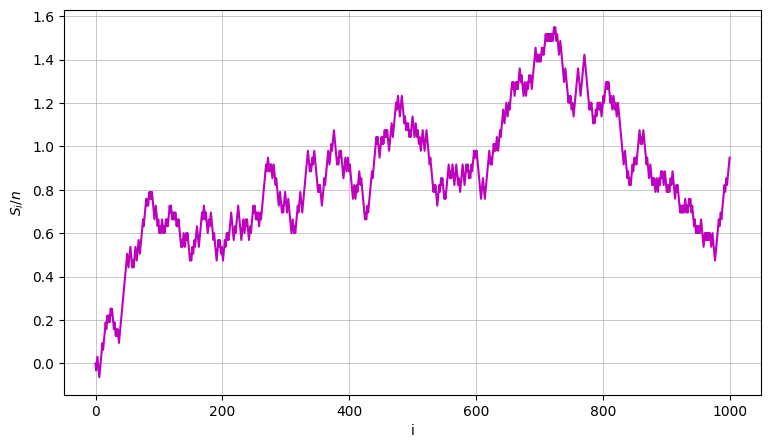

In [400]:
x = np.arange(0, n+1)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(x, y, color='m')

plt.xlabel('i')
plt.ylabel('$S_i/n$')
plt.show()

In [362]:
sample_orlyanka = gen_orlyanka_value(p, n, 10*N)

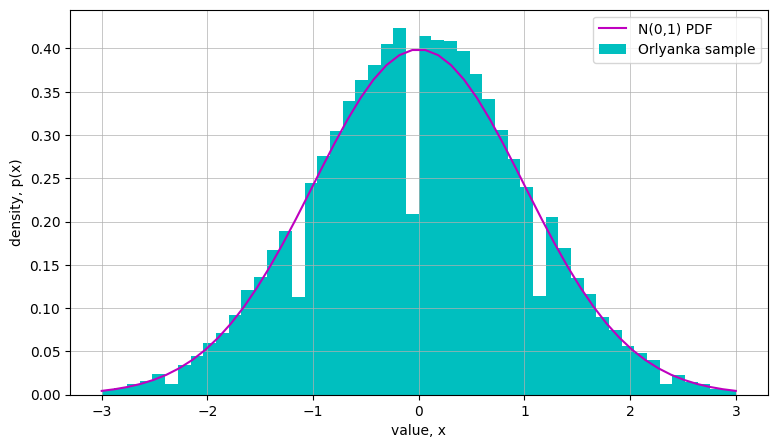

In [399]:
n_bins = 50
grid = np.linspace(-3, 3)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_orlyanka, bins=n_bins, range=(-3,3), density=True, color='c')
ax.plot(grid, norm.pdf(grid, loc=0.0, scale=1.0), color='m')

plt.xlabel('value, x')
plt.ylabel('density, p(x)')
plt.legend(['N(0,1) PDF', 'Orlyanka sample'])
plt.show()

## Задание 2

### Условие

1. Построить датчик сингулярного распределения, имеющий в качестве функции распределения канторову лестницу. 
С помощью критерия Колмогорова убедиться в корректности работы датчика.

2.  Для канторовых случайных величин с помощью критерия Смирнова проверить
свойство симметричности относительно $\frac{1}{2}$ ($X$ и $1 − X$ распределены одинаково)
и свойство самоподобия относительно деления на $3$ (условное распределение $Y$
при условии $Y ∈ [0, 1/3]$ совпадает с распределением $\frac{Y}{3}$).

3. Рассчитать значения математического ожидания и дисперсии для данного распределения. Сравнить теоретические значения с эмпирическими (для различных объемов выборок), проиллюстрировать сходимость эмпирических значений
к теоретическим.

### Генератор канторового распределения

Канторовская лестница задаётся на множестве Кантора (которое имеет нулевую меру Лебега) отрезка $[0,1]$, доопределяется по непрерывности в оставшихся точках. Канторовское распределение имеет функцию распределения, являющейся канторовской лестницей.

Есть два способа моделирования такого распределения:
1. По заданному $x\in[0,1]$. Канторовское множество состоит из тех точек, у которых нет единицы в троичной записи. Переведем $x$ в троичную запись, а затем отбросим все цифры после первой (самой левой) единицы.
2. По заданному размеру выборки $N$. Будем $N$ раз моделировать $n_{\operatorname{bits}}$ испытаний схемы Бернулли с $p=\frac{1}{2}$. Все единицы заменим на двойки, и получим троичную запись числа, в которой отсутствуют единицы.

Значением функции распределения $F(x)$ будет являться двоичное представление числа $x$. Его можно получить, заменив все двойки в троичной записи даного числа на единицы.

Число испытаний схемы Бернулли $n=n_{\operatorname{bits}}$ можно задавать с учётом заданной погрешности $\varepsilon$. В худшем случае отбрасываются двойки в троичной записи числа.
$$
\sum_{k=n+1}^{\infty} \dfrac{2^{k}}{3^{k}} = \dfrac{(\frac{2}{3})^{n+1}}{1 - \frac{2}{3}} < \varepsilon.
\quad\Rightarrow\quad
n + 1 < \log_{\frac{2}{3}}3\varepsilon.
$$

Будем генерировать канторовское распределение по заданному размеру выборки $N$ и точности $\varepsilon$.

In [ ]:
def rand_Cantor(N, eps):
    '''
    Cantor distribution with use of Bernoulli scheme
    returns (x, y) where x,y \in [0,1], y corresponds to cumulative distribution function (CDF)
    N - count of points, is positive integer number
    eps - precision, is positive float number
    additional error handling in rand_bern
    '''
    if not isinstance(N, (int, np.integer)) or N <= 0:
        raise ValueError("Count of points must be a positive integer.")
    if not eps > 0:
        raise ValueError("Presicion must be positive.")
    p = 0.5
    n_bits = np.floor(np.log(3*eps)/np.log(2/3) - 1).astype(int)
    sample = np.empty(N)
    cdf = np.empty(N)
    for i in range(N):
        # get binary representation of float number after point
        X = rand_bern(p, n_bits)
        curr_point = 0
        curr_value = 0
        for j in range(1, n_bits+1):
            # change representation
            curr_point += 2 * X[j-1] / 3**j       # from 3 to 10
            curr_value += X[j-1] / 2**j           # from 2 to 10
        sample[i] = curr_point
        cdf[i] = curr_value
    return np.sort(sample), np.sort(cdf)

In [112]:
N = 10**5
eps = 1e-12
n_bits = np.floor(np.log(3*eps)/np.log(2/3) - 1).astype(int)
print(n_bits)

64


In [113]:
sample_Cantor, cdf_Cantor = rand_Cantor(N, eps)
ecdf_Cantor = ecdf(sample_Cantor)

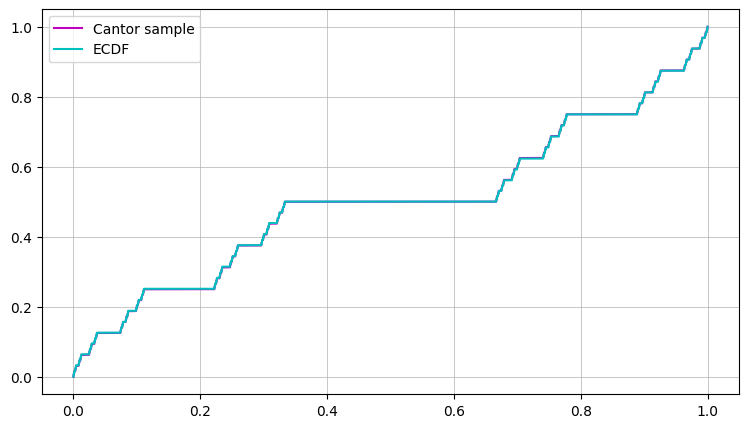

In [ ]:
M = N // 2
grid = np.linspace(0, 1, M+1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(sample_Cantor, cdf_Cantor, color='m', label='Cantor sample')
plt.plot(grid, ecdf_Cantor.cdf.evaluate(grid), color='c', label='ECDF')

plt.legend()
plt.show()

__Теорема__ (Колмогоров) Пусть $X_1,X_2,\dots,X_n$ — н.о.р.с.в. с непрерывной функцией распределения $F(x)$. \
Пусть $F_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbb{I}\{X_{(i)}<x\}$ — эмпирическая функция распределения (ECDF). \
Тогда 
$$
\forall x>0\quad \lim_{n\to\infty} \mathbb{P}({\sqrt{n}D_n < x}) = F_K(x),
$$
где $D_n=\sup\limits_{x\in\mathbb{R}}|F_n(x)-F(x)|$ — статистика Колмогорова и $F_K(\cdot)$ — функция распределения Колмогорова, которую можно выразить по формуле
$$
F_K(x) = 1 + 2 \sum_{k=1}^{+\infty}(-1)^k e^{-2k^2x^2}.
$$

Проверяем гипотезу
$$
H_0:~F(\cdot)=G(\cdot)
$$
с уровнем значимости $\alpha$, где $G=F_C(\cdot)$ — канторово распределение при помощи критерия Колмогорова.

Заметим, что $D_n$ является случайной величиной, ведь $F_n(x)$ зависит от реализации выборки. \
Теорема Колмогорова утверждает, что при истинности $H_0$ выполняется $\lim\limits_{n\to\infty} D_n = 0$, $\sqrt{n}D_n \sim F_K$ при $n\to\infty$.

Будем принимать $H_0$, если $1-F_K(\sqrt{n}D_n) > \alpha$.

In [ ]:
def dist_Kolmogorov(x):
    '''
    Value of Kolmogorov distribution
    returns approximation of distribution value
    '''
    N = 300000
    res = [-2 * k * k * x * x for k in range(1,N+1)]
    res = np.exp(res)
    res = [(-1) ** k * res[k-1] for k in range(1,N+1)]
    return 1 + 2 * np.sum(res)

def stat_Kolmogorov(F_ecdf, F_cdf):
    '''
    Value of Kolmogorov statistic
    F_ecdf and F_cdf are vectors, must be of same length
    '''
    if not len(F_ecdf) == len(F_cdf):
        raise ValueError('Given vectors must be of same length.')
    return np.max(np.abs(F_ecdf - F_cdf))

def test_Kolmogorov(sample, cdf_at_sample):
    '''
    Kolmogorov test
    returns p-value 
    sample and cdf_at_sample are vectors, must be of same length
    '''
    if not len(sample) == len(cdf_at_sample):
        raise ValueError('Given vectors must be of same length.')
    n = len(sample)
    F_ecdf = ecdf(sample).cdf.evaluate(sample)
    stat = stat_Kolmogorov(F_ecdf, cdf_at_sample)
    norm_stat = np.sqrt(len(sample)) * stat
    p_value = 1 - dist_Kolmogorov(norm_stat)
    return p_value

Проверяем истинность гипотезы при помощи критерия Колмогова $\operatorname{n\_tests}=1000$ раз с уровнем значимости $\alpha=0.05$ для смоделированных датчиком $\texttt{rand\_Cantor}$ выборок размера $N=2000$ с погрешностью $\varepsilon=10^{-6}$.

In [116]:
n_tests = 10
alpha = 0.05

N = 1000
eps = 1e-8

In [117]:
test_results_Kolmogorov = np.zeros(n_tests)
for i in range(n_tests):
    sample_Cantor, cdf_Cantor = rand_Cantor(N, eps)
    p_value = test_Kolmogorov(sample_Cantor, cdf_Cantor)
    test_results_Kolmogorov[i] = p_value

In [118]:
accept_count = np.count_nonzero((test_results_Kolmogorov > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 100.0% cases.


### Свойства канторового распределения

__Теорема__ (Смирнов) Пусть $X_1,X_2,\dots,X_n$ и $Y_1,Y_2,\dots,Y_m$, $m\leqslant n$ две независимые выборки, подчиняющиеся одному закону распределения $F(\cdot)\in C$, и $F_n(x),G_m(y)$ — соответствующие эмпирические функции распределения. Тогда
$$
\forall x\geqslant 0\quad \lim\limits_{n,m\to\infty}\mathbb{P}\left( \sqrt{\dfrac{nm}{n+m}}D_{nm} < x \right) = F_K(x),
$$
где $D_{nm} = \sup\limits_{x\in\mathbb{R}}|F_n(x) - G_m(x)|$ — статистика Смирнова и $F_K(\cdot)$ — функция распределения Колмогорова.


Пусть $X$  выборка, соответствующая канторовому распределения. 
1. Для проверки симметричности относительно $\frac{1}{2}$ выбираем $Y=1-X$.
2. Для проверки самоподобия относительно деления на 3 выбираем $\tilde{X}=\frac{X}{3}$, $Y=X$ при условии $X\in[0,\frac{1}{3}]$.

Проверяем гипотезу $H_0$ для двух выборок $X$ и $Y$ с функциями распределнения $F_X$ и $F_Y$:
$$
H_0:~ F_X(\cdot) = F_Y(\cdot) = F(\cdot)
$$
с уровнем значимости $\alpha$ при помощи критерия Смирнова.

Теорема Смирнова утверждает, что при истинности гипотезы $H_0$ верно $D_{nm}\to0$, $\sqrt{\frac{nm}{n+m}}D_{nm}\sim F_K$ при $n,m\to\infty$.

Будем принимать $H_0$, если $1-F_K(\sqrt{\frac{nm}{n+m}}D_n) > \alpha$.

In [ ]:
def stat_Smirnov(sample_X, sample_Y):
    '''
    Smirnov statistic
    sample_X and sample_Y are vectors (of different length)
    '''
    n_points = 10**5
    grid = np.linspace(
        np.min([sample_X.min(), sample_Y.min()]),
        np.max([sample_X.max(), sample_Y.max()]),
        num=n_points,
        endpoint=True
    )
    ecdf_X = ecdf(sample_X).cdf.evaluate(grid)
    ecdf_Y = ecdf(sample_Y).cdf.evaluate(grid)
    return np.max(np.abs(ecdf_X - ecdf_Y))

def test_Smirnov(sample_X, sample_Y):
    '''
    Smirnov test
    returns p-value
    sample_X and sample_Y are vectors (of different length)
    '''
    n = len(sample_X)
    m = len(sample_Y)
    stat = stat_Smirnov(sample_X, sample_Y)
    norm_stat = np.sqrt(n*m / (n+m)) * stat
    p_value = 1 - dist_Kolmogorov(norm_stat)
    return p_value

Проверяем симметричность относительно $\frac{1}{2}$.

In [ ]:
# n_tests = 1000
# alpha = 0.05

# N = 10**4
# eps = 1e-12

In [ ]:
n_tests = 5
alpha = 0.05

N = 10**4
eps = 1e-8

In [121]:
test_results_Smirnov = np.zeros(n_tests)
for i in range(n_tests):
    sample_Cantor_1, _ = rand_Cantor(N, eps)
    sample_Cantor_2, _ = rand_Cantor(N, eps)
    sample_Cantor_2 = 1 - sample_Cantor_2
    p_value = test_Smirnov(sample_Cantor_1, sample_Cantor_2)
    test_results_Smirnov[i] = p_value

In [122]:
accept_count = np.count_nonzero((test_results_Smirnov > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 100.0% cases.


In [123]:
sample_Cantor_1, cdf_Cantor_1 = rand_Cantor(N, eps)
sample_Cantor_2, _ = rand_Cantor(N, eps)
sample_Cantor_2 = 1 - sample_Cantor_2

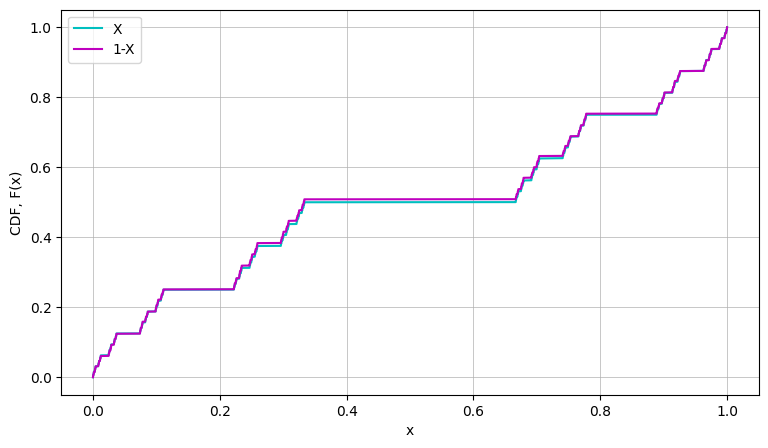

In [124]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(sample_Cantor_1, cdf_Cantor_1, color='c', label='X')
ax.plot(sample_Cantor_2, ecdf(sample_Cantor_2).cdf.evaluate(sample_Cantor_2), color='m', label='1-X')

plt.xlabel('x')
plt.ylabel('CDF, F(x)')
plt.legend()
plt.show()

Проверяем самоподобие относительно деления на 3.

In [ ]:
# n_tests = 100
# alpha = 0.05

# N = 10**4
# eps = 1e-12

In [125]:
n_tests = 5
alpha = 0.05

N = 10**4
eps = 1e-12

In [126]:
test_results_Smirnov = np.zeros(n_tests)
for i in range(n_tests):
    sample_Cantor_1, _ = rand_Cantor(N, eps)
    sample_Cantor_1 = sample_Cantor_1 / 3
    sample_Cantor_2, _ = rand_Cantor(N, eps)
    sample_Cantor_2 = sample_Cantor_2[sample_Cantor_2 < 1/3]
    p_value = test_Smirnov(sample_Cantor_1, sample_Cantor_2)
    test_results_Smirnov[i] = p_value

In [127]:
accept_count = np.count_nonzero((test_results_Smirnov > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 100.0% cases.


In [128]:
sample_Cantor_1, _ = rand_Cantor(N, eps)
sample_Cantor_1 = sample_Cantor_1 / 3
sample_Cantor_2, _ = rand_Cantor(N, eps)
sample_Cantor_2 = sample_Cantor_2[sample_Cantor_2 < 1/3]

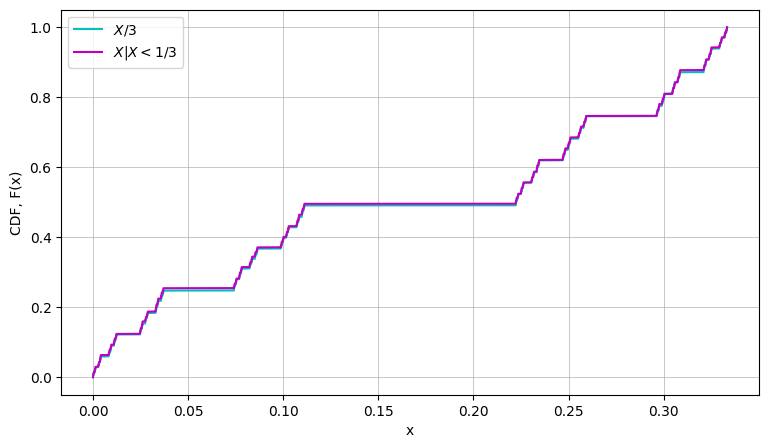

In [129]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(sample_Cantor_1, ecdf(sample_Cantor_1).cdf.evaluate(sample_Cantor_1), color='c', label='$X/3$')
ax.plot(sample_Cantor_2, ecdf(sample_Cantor_2).cdf.evaluate(sample_Cantor_2), color='m', label='$X|X<1/3$')

plt.xlabel('x')
plt.ylabel('CDF, F(x)')
plt.legend()
plt.show()

### Численные характеристики канторового распределения

__Утверждение__ ([закон полной вариации](https://en.wikipedia.org/wiki/Law_of_total_variance))
Пусть $X,Y$ - случайные величины на одном вероятностном пространстве и $\mathbb{D}X<\infty$. Тогда
$$
\mathbb{D}X = \mathbb{E}[\mathbb{D}(X|Y)] + \mathbb{D}(\mathbb{E}[X|Y]).
$$

Доказательство.\
По телескопическому свойству условного математического ожидания и определению дисперсии имеем
$$
\begin{aligned}
\mathbb{D}X &= \mathbb{E}X^2 - (\mathbb{E}X)^2 = \mathbb{E}[\mathbb{E}[X^2|Y]] - (\mathbb{E}[\mathbb{E}[X|Y]])^2 = \\
&= \mathbb{E}[\mathbb{D}(X|Y) + (\mathbb{E}[X|Y])^2] - (\mathbb{E}[\mathbb{E}[X|Y]])^2 = \\
&= \mathbb{E}[\mathbb{D}(X|Y)] + \underbrace{(\mathbb{E}[(\mathbb{E}[X|Y])^2] - (\mathbb{E}[\mathbb{E}[X|Y]])^2)}_{=\mathbb{D}(\mathbb{E}[X~|~Y])}=\\
&= \mathbb{E}[\mathbb{D}(X|Y)] + \mathbb{D}(\mathbb{E}[X|Y]).
\end{aligned}
$$.
Свойства условного математического ожидания и их доказательство можно найти в [2].

1. Математическое ожидание $X\sim F_C$, $F_C$ - канторово, равно $\frac{1}{2}$:
$$
\begin{aligned}
\mathbb{E}X &= \{X\stackrel{d}{=}1-X \} = \mathbb{E}[1-X] \\ 
\Rightarrow~\mathbb{E}X &= 1 - \mathbb{E}X \\ 
\Rightarrow~\mathbb{E}X &= \frac{1}{2}.
\end{aligned}
$$

2. Дисперсия $X\sim F_C$ равна $\frac{1}{8}$:
$$
\begin{aligned}
Y &\stackrel{def}{=} \mathbb{I}\left\{ X\in\left[\frac{2}{3},1\right]\right\}. \\
\mathbb{D}X &= \mathbb{E}[\mathbb{D}(X~|~Y)] + \mathbb{D}(\mathbb{E}[X~|~Y]). \\
\mathbb{E}[\mathbb{D}(X~|~Y)] &= \frac{1}{9}\mathbb{D}X \text{ (из свойства самоподобия)}. \\
\mathbb{E}[X~|~Y] &= \begin{cases}\begin{array}{cc}
\frac{1}{6},~ \text{с вероятностью } \frac{1}{2}, \\
\frac{1}{2},~ \text{с вероятностью } \frac{1}{2}.
\end{array}\end{cases}\text{ (из свойства симметричности)} \\
\mathbb{D}X &= \frac{1}{9}\mathbb{D}X + \frac{1}{9} \\
\Rightarrow~ \mathbb{D}X &= \frac{1}{8}.
\end{aligned}

In [150]:
N_start = 100
N_end = 10**3 + N_start
step = 100
eps = 1e-6

In [ ]:
# N_start = 10
# N_end = 10**6 + N_start
# step = 5 * 1000
# eps = 1e-12

In [151]:
iter_count = (N_end - N_start) // step + 1
mean_convergence_results = np.zeros(iter_count)
var_convergence_results = np.zeros(iter_count)
for i in range(0, iter_count):
    N_curr = N_start + i * step
    sample_Cantor, _ = rand_Cantor(N_curr, eps)
    mean_convergence_results[i] = sample_Cantor.mean()
    var_convergence_results[i] = sample_Cantor.var()

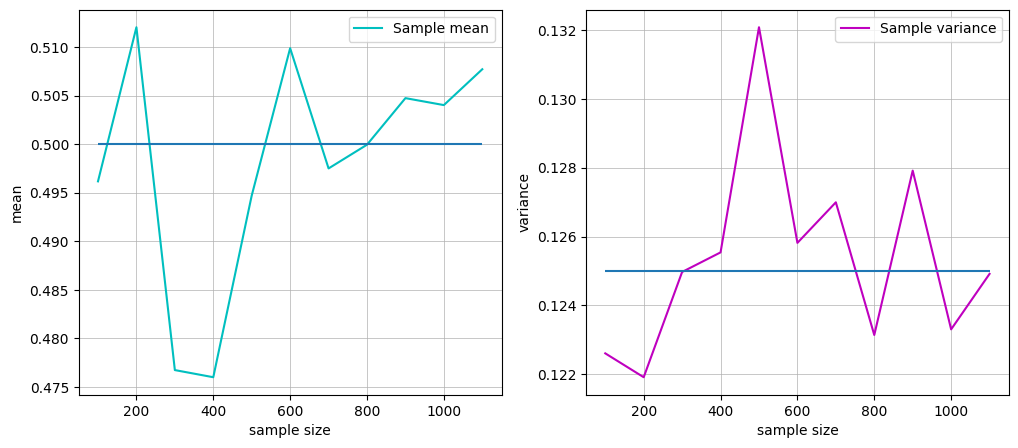

In [152]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

grid = np.arange(N_start, N_end + 1, step)

ax[0].grid('minor', linewidth=0.5)
ax[0].plot(grid, mean_convergence_results, color='c', label='Sample mean')
ax[0].hlines(0.5, N_start, N_end)
ax[0].legend(loc='upper right')
ax[0].set_xlabel('sample size')
ax[0].set_ylabel('mean')

ax[1].grid('minor', linewidth=0.5)
ax[1].plot(grid, var_convergence_results, color='m', label='Sample variance')
ax[1].hlines(0.125, N_start, N_end)
ax[1].legend(loc='upper right')
ax[1].set_xlabel('sample size')
ax[1].set_ylabel('variance')

# fig.suptitle('Mean and variance approximation')
plt.show()

## Задание 3

### Условие

1. Построить датчик экспоненциального распределения. Проверить для данного
распределения свойство остутствия памяти.

2. Пусть $X_1,X_2,\dots,X_n$ --- независимые экспоненциально распределенные случайные величины с параметрами
$\lambda_1,\lambda_2,\dots,\lambda_n$. Найти распределение случайной величины $Y=\min\{X_1,X_2,\dots,X_n\}$.

3. На основе датчика экспоненциального распределения построить датчик пуассоновского распределения.

4. Построить датчик пуассоновского распределения как предел биномиального распределения. Убедиться в корректности
построенного датчика при помощи критерия $\chi^2$ Пирсона.

5. Построить датчик стандартного нормального распределения методом моделирования случайных величин парами с переходом в полярные координаты 
(преобразование Бокса-Мюллера). Проверить при помощи t-критерия Стьюдента равенство математических ожиданий, а при помощи критерия Фишера — 
равенство дисперсий.

### Генератор экспоненциального распределения

Экспоненциальное распределение - абсолютно непрерывное распределение с плотностью $\lambda e^{-\lambda x},~\lambda>0$.

Рассмотрим $\lambda > 0$. Будем генерировать случайную величину
$$
\xi = -\frac{1}{\lambda}\ln\nu,\quad \nu\sim\mathrm{U}[0,1].
$$
Она имеет экспоненциальное распределение $\mathrm{Exp}(\lambda)$, ведь
$$
\mathbb{P}(\xi < x) = \mathbb{P}(-\frac{1}{\lambda}\ln\nu < x) = \mathbb{P}(\nu > e^{-\lambda x}) = 1 - e^{-\lambda x}.
$$

In [153]:
def rand_expo(l, *args):
    '''
    Exponential distribution generator
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    return -np.log(np.random.rand(*args)) / l

In [508]:
L = 0.5
N = 10**5
sample_exponential = rand_expo(L, N)

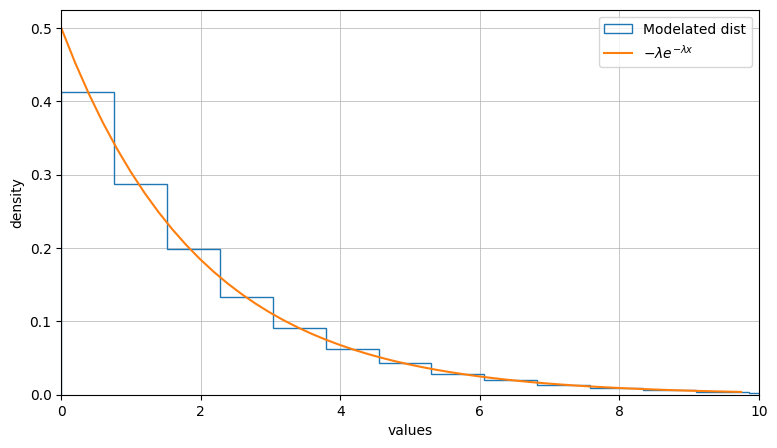

In [519]:
n_bins = 30

alpha = 0.01
xlim = np.ceil(-np.log(alpha)/L)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

x = np.linspace(0, sample_exponential.max() * 3/7)
ax.hist(sample_exponential, 
    bins=n_bins,
    density=True, 
    histtype='step', 
    label='Modelated dist'
)
ax.plot(x, L * np.exp(-L * x), label='$-\lambda e^{-\lambda x}$')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

Проверим свойство отсутствия памяти аналогично геометрическому распределению.

In [545]:
L = 0.5
N = 10**6
m = 5

In [546]:
sample_expo_1 = rand_expo(L, N)
sample_expo_2 = rand_expo(L, N)
sample_expo_2 = sample_expo_2[sample_expo_2 > m]

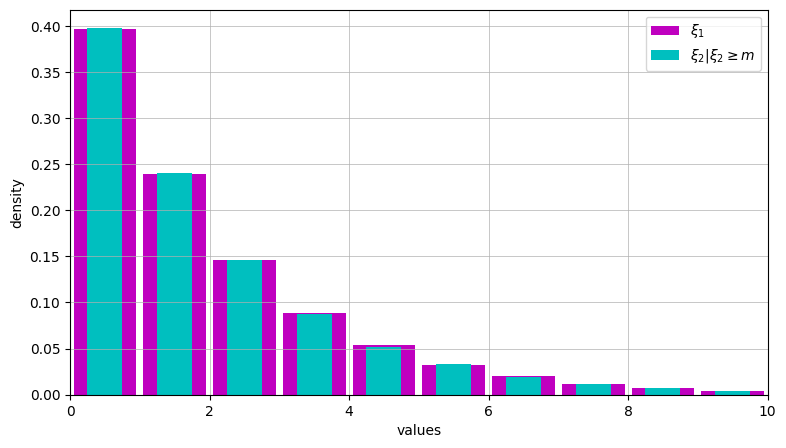

In [554]:
alpha = 0.01
xlim = np.ceil(-np.log(alpha)/L)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

ax.hist(sample_expo_1, density=True, rwidth=0.9, range=(0, xlim), color='m', label='$\\xi_1$')
ax.hist(sample_expo_2 - m, density=True, rwidth=0.5, range=(0, xlim), color='c', label='$\\xi_2|\\xi_2\\geq m$')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

### Распределение $Y=\min\{X_1,X_2,\dots,X_n\}$.

Имеем
$$
X_k \sim \mathrm{Exp}(\lambda_k),~ k\in\overline{0,n} \text{ --- i.i.d.r.v.}
$$

Генератор строим из следующих соображений.
$$
\begin{aligned}
\mathbb{P}(Y < x) &= 1 - \mathbb{P}(\min\{X_1,X_2,\dots,X_n\} \geqslant x) = \\
&= 1 - \mathbb{P}(X_1 \geqslant x, X_2 \geqslant x, \dots, X_n \geqslant x) = \{\text{независимость}\} = \\
&= 1 - \prod_{k=1}^{n}\mathbb{P}(X_k \geqslant x) = 1 - \prod_{k=1}^{n}(1 - \mathbb{P}(X_k < x)) = \\
&= 1 - \prod_{k=1}^{n}e^{-\lambda_kx} = 1 - e^{-(\lambda_1+\lambda_2+\dots+\lambda_n)x}.
\end{aligned}
$$
Получили, что $Y\sim\mathrm{Exp}(\sum_{k=1}^n\lambda_k)$.

Докажем полученное эмпирически. \
Для этого построим эмпирические функции распределения $Y$ по явной формуле и $Y$ как экспоненциальное распределение.

In [522]:
def gen_minimum_expo(lambdas, *args):
    '''
    Y=\min{X_1,X_2,...,X_n}, X_i~Exp(\lambda_i) generator
    returns tensor with given shapes
    lambdas - vector of positive parameters of length n
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_expo
    '''
    n = len(lambdas)
    X = np.empty([n, *args])
    for k in range(n):
        X[k] = rand_expo(lambdas[k], *args)
    return np.min(X, axis=0)

In [527]:
N = 1000
n = 100
lambdas = 7 * np.random.rand(n)

In [533]:
Y_sample_1 = gen_minimum_expo(lambdas, N)
Y_sample_2 = rand_expo(lambdas.sum(), N)

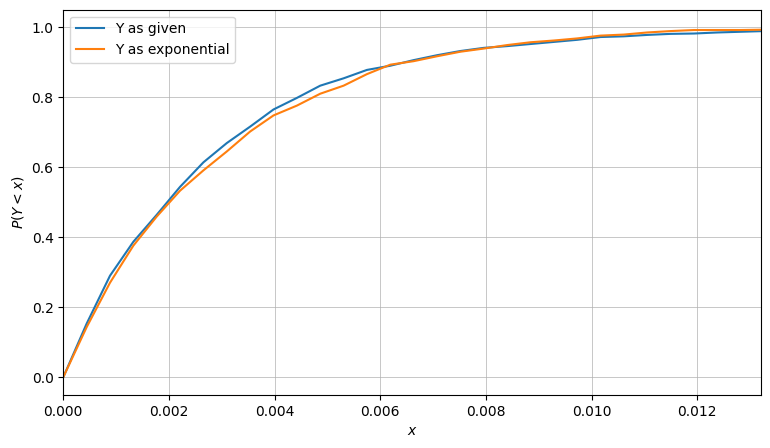

In [534]:
alpha = 0.01
xlim = -np.log(alpha)/lambdas.sum()

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

grid = np.linspace(0, max(Y_sample_1.max(), Y_sample_2.max()))
ecdf_expo_1 = ecdf(Y_sample_1).cdf.evaluate(grid)
ecdf_expo_2 = ecdf(Y_sample_2).cdf.evaluate(grid)
ax.plot(grid, ecdf_expo_1, label='Y as given')
ax.plot(grid, ecdf_expo_2, label='Y as exponential')

plt.ylabel('$P(Y < x)$')
plt.xlabel('$x$')
plt.legend()
plt.show()

### Генератор пуассоновского распределения (через г-р экспоненциального р-я)

Пуассоновская случайная величина $X$ с параметром $\lambda > 0$ принимает значения $k\in\{0,1,2,\dots\}\equiv\mathbb{N}_0$, является дискретной:
$$
\mathbb{P}(X = k) = e^{-\lambda}\dfrac{1}{k!}\lambda^k.
$$
Причём $\mathbb{E}X=\mathbb{D}X=\lambda$.

Воспользуемся следующей теоремой.

__Теорема__. Пусть $X_1,X_2,\dots,X_n$ - н.о.р.с.в., $X_i\sim\mathrm{Exp}(\lambda),\lambda>0$. \
Положим $Y$ - наименьшее неотрицательное целое число такое, что
$$
\sum_{k=1}^{Y+1}X_i > 1.
$$
Тогда $Y\sim\mathrm{Pois}(\lambda)$.

Доказательство можно найти в [3], с.501 (ошибка в формулировке теоремы)

In [174]:
def rand_poisson_expo(l):
    '''
    Poisson distribution generator, derivative of rand_expo
    returns realization of one random value
    l - parameter, must be positive
    error handling in rand_expo
    '''
    Y = 0
    summ = 0
    while True:
        summ += rand_expo(l)
        if summ > 1:
            return Y
        else:
            Y += 1

def rand_poisson_expo_vec(l, *args):
    '''
    Poisson distribution generator, derivative of rand_expo
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_expo
    '''
    if not args:
        return rand_poisson_expo(l)
    else:
        Y = np.zeros(*args)
        summ = np.zeros(*args)
    while True:
        X = rand_expo(l, *args)
        summ = summ + X
        Y[summ < 1] = Y[summ < 1] + 1
        if not np.any(Y[summ < 1]):
            return Y

In [536]:
N = 10**5
L = 10

In [537]:
sample_poisson_expo = rand_poisson_expo_vec(L, N)
print(f'mean={sample_poisson_expo.mean():.6}, variance={sample_poisson_expo.var():.6}')

mean=10.004, variance=10.0151


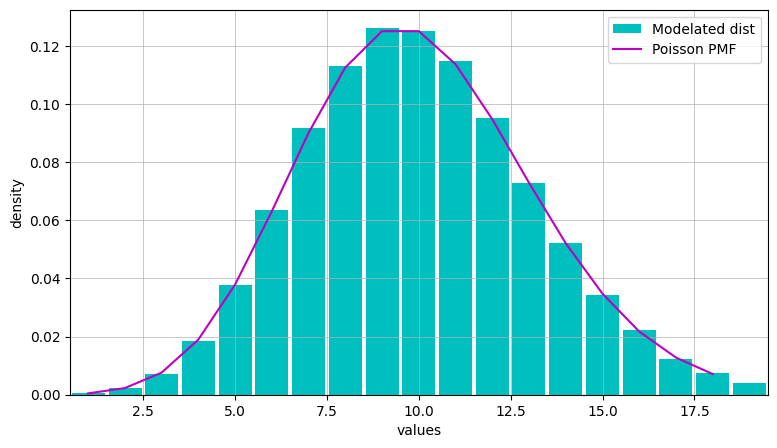

In [541]:
n_bins = 19
grid = np.arange(np.ceil(L - 3*np.sqrt(L)), np.floor(L + 3*np.sqrt(L)))

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([L - 3*np.sqrt(L), L + 3*np.sqrt(L)])

ax.hist(sample_poisson_expo,
    bins=n_bins,
    density=True,
    rwidth=0.9,
    range=(L - 3*np.sqrt(L), L + 3*np.sqrt(L)),
    label='Modelated dist',
    color='c'
)
ax.plot(grid, poisson.pmf(grid, mu=L), color='m', label='Poisson PMF')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

### Генератор пуассоновского распределения (через г-р биномиального р-я)

Воспользуемся Теоремой Пуассона.

__Теорема__ (Пуассон). Пусть есть последовательность биномиально распределенных случайных величин $X_n\sim\mathrm{Bin}(n, p_n)$ такая, что
1. $n\to\infty$.
2. $np_n\to\lambda,~n\to\infty$.

Тогда $\lim\limits_{n\to\infty}\mathbb{P}(X_n = m) = \dfrac{\lambda^m}{m!}e^{-\lambda}$.

Доказательство приведено в [2], Гл. I, §6, п.4.

Будем моделировать выборку-вектор пуассоновского распределения при помощи последовательного запуска $\texttt{rand\_bin}$.

In [438]:
def rand_poisson_bin(l, N):
    '''
    Poisson distribution generator, derivative of rand_bin
    returns vector of length N
    l - parameter, must be positive
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    n = 10**4
    p_n = l / n
    batch_size = 5 * 10**3
    result = np.zeros(N)
    for i in range(0, N // batch_size + 1):
        if (i+1)*batch_size >= N:
            result[i*batch_size:] = rand_bin(n, p_n, N - i*batch_size)
        else:
            result[i*batch_size:(i+1)*batch_size] = rand_bin(n, p_n, batch_size)
    return result

In [439]:
N = 10**6
L = 12

In [440]:
sample_poisson_bin = rand_poisson_bin(L, N)

(np.float64(12.000318), np.float64(12.010145898875995))

In [445]:
print(f'mean={sample_poisson_bin.mean():.6}, variance={sample_poisson_bin.var():.6}')

mean=12.0003, variance=12.0101


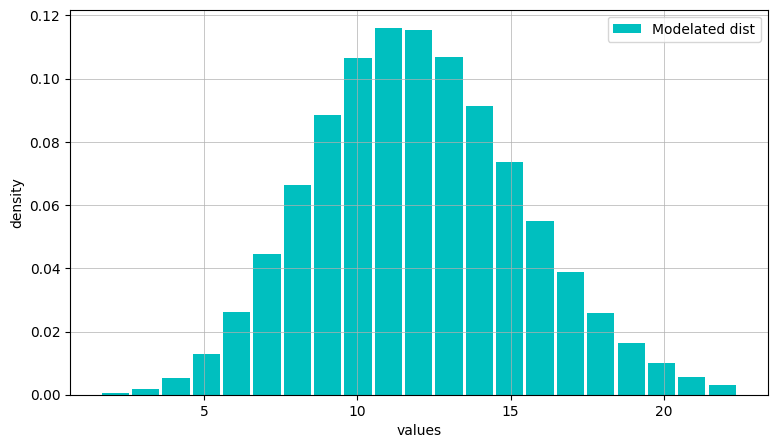

In [446]:
n_bins = 21

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_poisson_bin,
    bins=n_bins,
    density=True,
    label='Modelated dist',
    range=(L - 3*np.sqrt(L), L + 3*np.sqrt(L)),
    rwidth=0.9,
    color='c'
)

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

Проверяем гипотезу о виде функции распределения $X$ при помощи критерия $\chi^2$ Пирсона:
$$
H_0:~ F_X(\cdot) = F_{\operatorname{Pois}}(\cdot)
$$
с уровнем значимости $\alpha$, где $F_{\operatorname{Pois}}(\cdot)$ - функция распределения $\mathrm{Pois}(10)$.

Выберем разбиение $T$ размера $m=15$ области определения распределения ($\mathbb{N}_0$):
$$
T = \bigcup_{k=1}^{15} T_k,~
T_1 = \{0,1,2,3,4\},~T_k=\{k+3\},k=\overline{2,14},~T_{15}=\{k\geqslant18\}.
$$
Вычисляем теоретические вероятности $p_k=\mathbb{P}(X \in T_k)$ при условии истинности $H_0$. \
Вычисляем $l_k$ - число попаданий значений выборки $X$ в множество $T_k$.

Согласно критерию $\chi^2$ Пирсона при истинности гипотезы $H_0$ статистика $\chi^2$:
$$
\chi^2 = \sum^{m}_{k=1} \dfrac{(l_k - np_k)^2}{np_k} = \sum^{m}_{k=1}\dfrac{n}{p_k}\left( \dfrac{l_k}{n} - p_k \right)^2.
$$
имеет распределение $\chi^2_{m-1}$.

Будем принимать гипотезу, если $1-F_{\chi^2_{m-1}}(\chi^2) > \alpha$.

In [502]:
def stat_chi2(sample_size, model_freqs, teor_freqs):
    '''
    Chi2 statistic
    sample_size is positive integer
    model_freqs and teor_freqs are vectors of same length and values in [0,1]
    '''
    if not isinstance(sample_size, (int, np.integer)) or sample_size <= 0:
        raise ValueError('Sample size must be a positive integer.')
    if model_freqs.min() < 0 or model_freqs.max() > 1:
        raise ValueError('Model frequencies must be in range [0,1].')
    if teor_freqs.min() < 0 or teor_freqs.max() > 1:
        raise ValueError('Model frequencies must be in range [0,1].')
    if len(model_freqs) != len(teor_freqs):
        raise ValueError('Given vectors must be of same length.')
    squares = np.power(model_freqs - teor_freqs, 2)
    return np.sum(np.divide(N * squares, teor_freqs))

def test_chi2(sample_size, model_freqs, teor_freqs):
    '''
    Chi-square test
    returns p-value
    sample_size is positive integer
    model_freqs and teor_freqs are vectors of same length and values in [0,1]
    error handling in stat_chi2
    '''
    stat = stat_chi2(sample_size, model_freqs, teor_freqs)
    p_value = 1 - chi2.cdf(stat, df=len(model_freqs))
    return p_value

def count_matches(target, values):
    target_set = set(target)
    return sum(1 for value in values if value in target_set)

In [498]:
n_tests = 100
alpha = 0.05

L = 10
N = 10**4

split_size = 15
split_lower_bound = 4
split_upper_bound = split_size + split_lower_bound - 1
pmf_upper_bound = 40

In [499]:
# calculate teoretical frequencies
poisson_pmf = poisson.pmf(np.arange(0, pmf_upper_bound), mu=L)
teor_freqs = np.zeros(split_size)
teor_freqs[0] = poisson_pmf[:split_lower_bound+1].sum()
teor_freqs[1:split_size-1] = poisson_pmf[split_lower_bound+1:split_upper_bound]
teor_freqs[-1] = poisson_pmf[split_upper_bound:].sum()

In [503]:
test_results_Pearson = np.zeros(n_tests)

T_1 = np.arange(0, split_lower_bound+1)

for i in range(n_tests):
    model_freqs = np.zeros(split_size)
    sample_poisson_bin = rand_poisson_bin(L, N)
    # calculate modelated frequencies
    model_freqs = np.zeros(split_size)
    model_freqs[0] = count_matches(T_1, sample_poisson_bin) / N
    for k in range(1, split_size):
        model_freqs[k] = np.count_nonzero((sample_poisson_bin == split_lower_bound + k).astype(int)) / N
    model_freqs[-1] = np.count_nonzero((sample_poisson_bin >= split_upper_bound).astype(int)) / N
    # calculate p-value
    p_value = test_chi2(N, model_freqs, teor_freqs)
    test_results_Pearson[i] = p_value

In [496]:
accept_count = np.count_nonzero((test_results_Pearson > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 94.0% cases.


### Генератор стандартного нормального распределения (преобразование Бокса-Мюллера)

__Теорема__ Пусть $\xi_1,\xi_2$ - независимые стандартно нормально распределенные случайные величины.
Тогда их можно представить в виде
$$
\begin{cases}
\xi_1 = \sqrt{\omega}\cos\nu,\\
\xi_2 = \sqrt{\omega}\sin\nu.
\end{cases}
$$
где $\nu\sim\mathrm{U}[0,2\pi], \omega\sim\mathrm{Exp}(\frac{1}{2})$ - независимые.

Доказательство. \
Покажем, что совместные плотности векторов $(\xi_1,\xi_2), (\sqrt{\omega}\cos\nu, \sqrt{\omega}\sin\nu)$ совпадают. \
Для этого достаточно перейти к полярным координатам под знаком интеграла:
$$
\begin{aligned}
\mathbb{P}(X_1<x, X_2<y) &= \int_{-\infty}^{x}\int_{+\infty}^{y} \dfrac{1}{2\pi}e^{-\frac{x_1^2+x_2^2}{2}}dx_2dx_1 = \\
&= \biggl\vert \begin{array}{c}
x_1 = r\cos\alpha, \\ 
x_2 = r\sin\alpha.
\end{array} \biggr\vert = \iint\limits_{\begin{array}{c}r\cos\alpha<x\\ r\sin\alpha<y\end{array}} \dfrac{1}{2\pi}e^{-\frac{r^2}{2}}rdrd\alpha = \\
&= \{ \omega = r^2, d\omega = 2rdr \} = \\
&= \iint\limits_{\begin{array}{c}\sqrt{\omega}\cos\alpha<x\\ \sqrt{\omega}\sin\alpha<y\end{array}} \dfrac{1}{2\pi}e^{-\frac{\omega}{2}}\frac{1}{2}d\omega d\alpha = \mathbb{P}(\xi_1 < x, \xi_2 < y).
\end{aligned}
$$

In [ ]:
def rand_norm_expo(*args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns tensor with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return np.sqrt(omega) * np.cos(alpha)

def rand_norm_pair(*args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns pair of tensors with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return np.sqrt(omega) * np.cos(alpha), np.sqrt(omega) * np.sin(alpha)

In [556]:
N = 10**6
mu = 0
sigma = 1
n_points = 100

In [557]:
sample_norm_expo = rand_norm_expo(N)

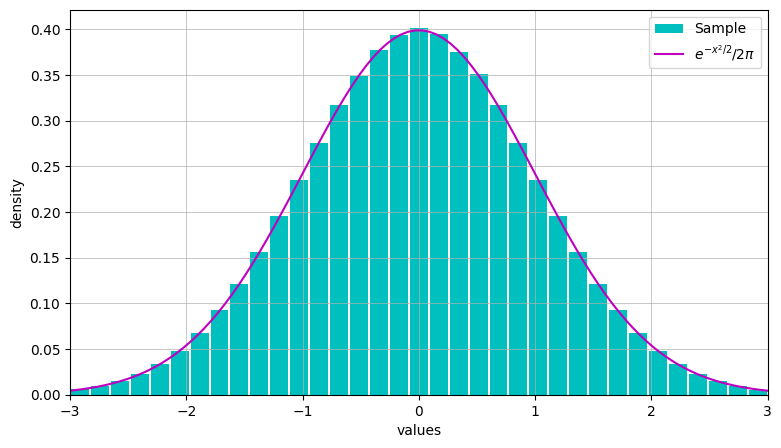

In [561]:
n_bins = 35
grid = np.linspace(mu - 3*sigma, mu + 3*sigma, n_points)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([mu - 3*sigma, mu + 3*sigma])

ax.hist(sample_norm_expo, bins=n_bins, density=True, range=(mu - 3*sigma, mu + 3*sigma), rwidth=0.9, color='c', label='Sample')
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), color='m', label='$e^{-x^2/2}/2\pi$')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

__Утверждение__ (Стьюдент) \
Пусть $X_1,X_2,\dots,X_n$ - независимые случайные величины такие, что $X_i\sim\mathrm{N}(\mu,\sigma^2), i=\overline{1,n}$.
Положим $\overline{X}$ - выборочное среднее, $S^2$ - несмещенная выборочная дисперсия. Тогда
$$
T=\dfrac{\overline{X}-\mu}{S/\sqrt{n}}\sim t(n-1),
$$
где $t(n-1)$ - распределение Стьюдента с $(n-1)$ степенями свободы.

Проверяем гипотезу о равенстве мат. ожидания конкретному значению одной нормально распределенной выборки при помощи t-критерия Стьюдента:
$$
H_0:~ \mathbb{E}X = \mu.
$$

Согласно утверждению Стьюдента при истинности гипотезы $H_0$ статистика $T$ имеет распределение $t(n-1)$. \
Отметим, что критерий Стьюдента имеет двустороннюю критическую область.

Будем принимать $H_0$, если $|T| < K_\alpha = F^{-1}_{t(n-1)}(1-\alpha/2)$.

Нужные значения возьмём из [таблицы](https://ru.wikipedia.org/wiki/%D0%9A%D0%B2%D0%B0%D0%BD%D1%82%D0%B8%D0%BB%D0%B8_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0): при $\alpha=0.05, n=10^4 + 1$ квантиль $K_\alpha = 1.9623$.

In [65]:
def stat_Student(sample, loc=0.0):
    sample_mean = sample.mean()
    sample_std = sample.std(ddof=1)     # ddof=1 for division by sqrt(n-1)
    return (sample_mean - loc) / (sample_std / np.sqrt(len(sample)))

def test_Student(sample, quantile, loc=0.0):
    stat = stat_Student(sample, loc)
    return np.abs(stat) < quantile

In [66]:
n_tests = 10**3
t_quantile = 1.9623

mu = 2.5
sigma = 1.25
N = 10**5

In [67]:
test_results_Student = np.zeros(N)
for i in range(n_tests):
    sample_norm = sigma * rand_norm_expo(N) + mu
    test_results_Student[i] = test_Student(sample_norm, t_quantile, mu)

In [68]:
accept_count = np.count_nonzero(test_results_Student.astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 95.7% cases.


Проверяем гипотезу о равенстве дисперсий двух независимых нормально распределенных выборок при помощи критерия Фишера:
$$
H_0:~ \mathbb{D}X = \mathbb{D}Y = \sigma^2.
$$

При истинности гипотезы $H_0$ для выборок $X$ (размера $n$) и $Y$ (размера $m$) статистика
$$
D = \dfrac{S^2_X}{S^2_Y} \sim F(m-1,n-1),
$$
где $F(m-1,n-1)$ - распределение Фишера со степенями свободы $n-1$ и $m-1$. \
Отметим, что критерий Фишера также имеет двустороннюю критическую область.

Будем принимать $H_0$, если $D\in (K_{\alpha/2}, K_{1-\alpha/2})$, где $K_{\alpha/2}=F^{-1}_{F(n-1,m-1)}(\alpha/2), K_{1-\alpha/2}=F^{-1}_{F(n-1,m-1)}(1-\alpha/2)$.

In [ ]:
def stat_Fisher(sample_X, sample_Y):
    '''
    Fisher statistic
    sample_X and sample_Y are vectors (of different length)
    '''
    sample_X_var = np.var(sample_X, ddof=1) # ddof=1 for division by sqrt(n-1)
    sample_Y_var = np.var(sample_Y, ddof=1)
    return sample_X_var / sample_Y_var

def test_Fisher(sample_X, sample_Y, alpha):
    '''
    Fisher test
    returns boolean value of hypothesis acceptance
    sample_X and sample_Y are vectors (of different length)
    '''
    N = len(sample_X)
    M = len(sample_Y)
    stat = stat_Fisher(sample_X, sample_Y)
    # we use percent point function of central F-distribution
    # best practice is to compute quantiles only once
    # but documentation says that test_ functions must contain alpha as parameter
    f_quantile_1 = f.ppf(alpha/2, N-1, M-1)
    f_quantile_2 = f.ppf(1 - alpha/2, N-1, M-1)
    return stat > f_quantile_1 and stat < f_quantile_2

In [70]:
mu = 2.5
sigma = 1.25
N = 600 + 1
M = 1000 + 1

n_tests = 100
alpha = 0.05

In [71]:
test_results_Fisher = np.zeros(n_tests)
for i in range(n_tests):
    sample_X = sigma * rand_norm_expo(N) + mu
    sample_Y = sigma * rand_norm_expo(M) + mu
    test_results_Fisher[i] = test_Fisher(sample_X, sample_Y, alpha)

In [72]:
accept_count = np.count_nonzero(test_results_Fisher.astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 95.0% cases.


## Задание 4

### Условие

1. Построить датчик распределения Коши.

2. На основе датчика распределения Коши с помощью метода фон Неймана построить датчик стандартного нормального распределения. При помощи 
графика normal probability plot убедиться в корректности построенного датчика и обосновать наблюдаемую линейную зависимость.

3. Сравнить скорость моделирования стандартного нормального распределения в задании 3 и в задании 4.

### Генератор распределения Коши

Распределение Коши $\mathrm{C}(x_0,\gamma)$ - абсолютно непрерывное распределение с плотностью
$$
\dfrac{1}{\pi\gamma\left(1+(\frac{x-x_0}{\gamma})^2 \right)},
$$
где $x_0$ - параметр сдвига, $\gamma>0$ - параметр масштаба.

Пусть $X\sim\mathrm{C}(x_0,\gamma)$. Тогда
$$
\begin{aligned}
F_X(x) &= \dfrac{1}{\pi}\operatorname{arctg}\left(\dfrac{x-x_0}{\gamma}\right) + \dfrac{1}{2}, \\
F_X^{-1}(x) &= x_0 + \gamma\tg\left[\pi\left(x-\dfrac{1}{2}\right)\right].
\end{aligned}
$$

In [73]:
def rand_Cauchy(loc=0.0, scale=1.0, *args):
    if scale < 0:
        raise ValueError('Scale must be positive float number.')
    return loc + scale * np.tan(np.pi * (np.random.rand(*args) - 0.5))

Продемонстрируем отсутствие математического ожидания у распределения Коши.

In [74]:
loc = 5
scale = 2

n_runs = 200
N = 10**6

In [75]:
results_runs = np.zeros(n_runs)
for i in range(n_runs):
    sample_Cauchy = rand_Cauchy(loc, scale, N)
    results_runs[i] = sample_Cauchy.mean()

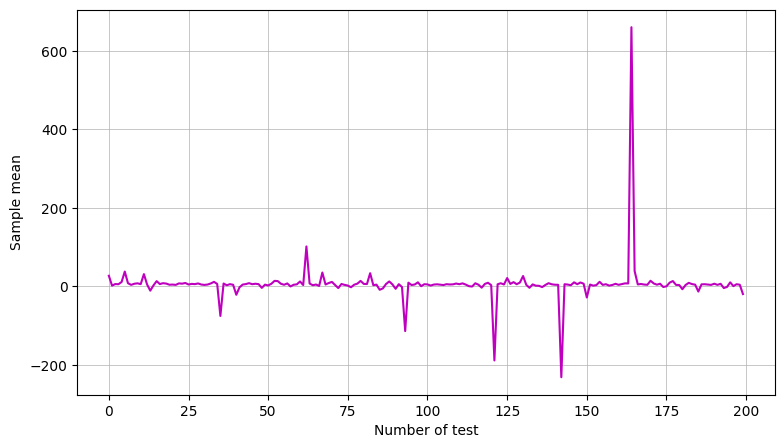

In [76]:
n_bins = 30

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(results_runs, c='m')

plt.ylabel('Sample mean')
plt.xlabel('Number of test')
plt.show()

### Генератор стандартного нормального распределения (через г-р распределения Коши)

Метод элиминации фон Нейманна: \
Ставится задача моделирования распределения с плотностью $f(x)$ со значениями в $\mathbb{R}^n.$ \
Пусть имеются $X\sim g(x)$ и $U\sim \mathrm{U}[0,1]$ - две случайные величины, $g(x)$ принимает значения в $\mathbb{R}^n$. \
Также имеется константа $c\geqslant 1$.

Можно показать, что случайный вектор $(X, cUg(X))\sim\mathrm{U}(A)$, где $A=\{(x,u)~|~x\in\mathbb{R}^n,0\leqslant u\leqslant cf(x)\}$.

Алгоритм моделирования на псевдокоде:
```python
while True
    X = ... # моделируем X
    U = ... # моделируем U
    T = c * g(X) / f(X)
    if U*T <= 1:
        break
```

Доказательство, обоснование корректности приведены в [3], с. 40-46.

Обоснованность алгоритма моделирования для $f(x)=\dfrac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$ приведена там же, с. 46.

In [141]:
def rand_norm_Cauchy():
    alpha = np.sqrt(np.exp(1)) / 2
    while True:
        X = rand_Cauchy(0, 1)
        U = np.random.rand()
        S = X * X
        if U < alpha * (1 + S) * np.exp(-S/2):
            return X

def rand_norm_Cauchy_vec(N):
    alpha = np.sqrt(np.exp(1)) / 2
    result = np.zeros(N)
    while True:
        count = (result == 0).astype(int)
        X = rand_Cauchy(0, 1, count)
        # print(result == 0)
        # X[result == 0] = rand_Cauchy(0, 1, *(X[result == 0].shape))
        # S = X[result == 0] * X[result == 0]
        # U = np.random.rand(*(X[result == 0].shape))
        # ind = U < alpha * (1 + S) * np.exp(-S/2)
        # if ind.any():
        #     result[ind] = X[ind]
        # if (result != 0).all():
        #     return result

In [147]:
X = rand_norm_Cauchy_vec(3)

[ True  True  True]


In [148]:
X

array([-0.50941141,  0.91160698, -0.69958064])

In [81]:
N = 100
test = rand_norm_Cauchy_vec(N)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 100 but size of corresponding boolean axis is 38

In [156]:
N = 10**6
test = np.zeros(N)
for i in range (1, N+1):
    test[i-1] = rand_norm_Cauchy()

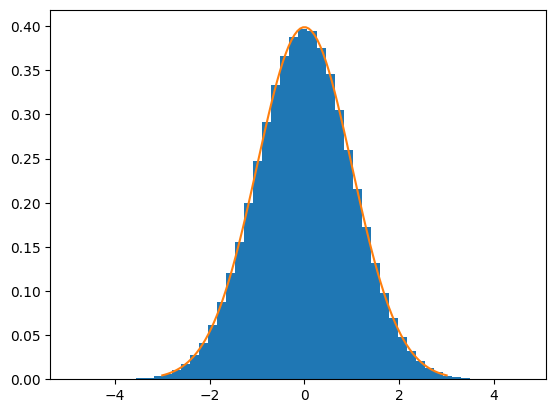

In [157]:
grid = np.linspace(-3, 3, 100)
plt.hist(test, bins=50,density=True)
plt.plot(grid, norm.pdf(grid))

Функция $\texttt{normplot}$ среды разработки $\texttt{MATLAB}$ сравнивает квантили выборки с квантилями нормального распределения. По оси абсцисс отображается сортированные значения выборки, по оси ординат - квантили нормального распределения.

Мы будем пользоваться функцией $\texttt{scipy.stats.probplot}$ (имеется аналог в $\texttt{MATLAB}$), которая строит Q-Q plot (quantile-quantile plot).

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([-4.88297243, -4.84108379, -4.67039653, ...,  4.60608386,
          4.61417096,  4.63028588])),
 (np.float64(0.9990691745265221),
  np.float64(0.0020766403953258183),
  np.float64(0.9999988282554148)))

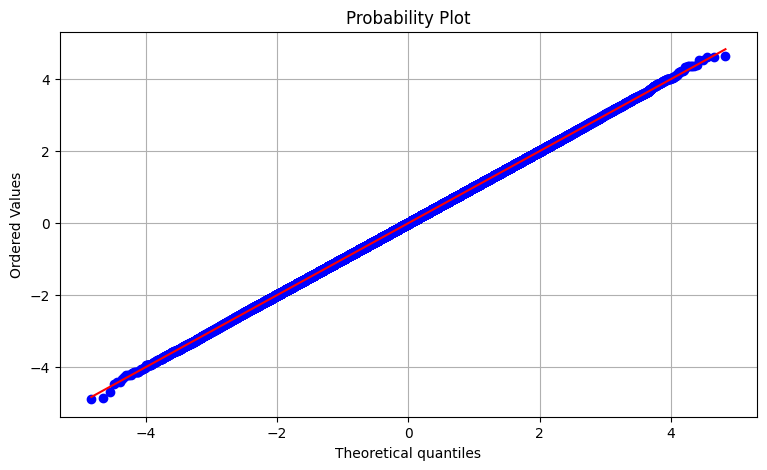

In [158]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor')
probplot(test, dist='norm', fit=True, plot=ax)

### Сравнение скорости сходимости

In [ ]:
%timeit rand_norm_expo()

4.41 µs ± 77.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [154]:
%timeit rand_norm_Cauchy()

8.36 µs ± 58.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Задание 5

### Условие

1. Пусть $X\sim \mathcal{N}(\mu,\sigma^2)$. Убедиться эмпирически в справедливости теоремы о законе больших чисел (ЗБЧ) и центральной предельной теоремы (ЦПТ): исследовать поведение суммы $S_n = \sum\limits_{i=1}^n X_i$ и эмпирического распределения величины
$$
\sqrt{n}\dfrac{S_n}{n} - a.
$$

2. Считая $\mu$, $\sigma$ неизвестными, построить доверительные интервалы для среднего и дисперсии по имеющейся выборке.

3. Пусть $X_i \sim K(a,b)$ --- имеет распределение Коши с параметрами сдвига $a$ и масштаба $b$. Изучить эмпирически как ведут себя суммы $\frac{S_n}{n}$, объяснить результат и найти закон распределения данных сумм.

## Задание 6

### Условие

1. Вычислить следующий интеграл:
$$
\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\cdots\int_{-\infty}^{\infty}\dfrac{e^{-(x_1^2+x_2^2+\dots+x_{10}^2 + \frac{1}{2^7\cdot x_1^2\cdots x_{10}^2})}}{x_1^2\cdot\dots\cdot x_{10}^2}dx_1dx_2\dots dx_{10}
$$

- Методом Монте-Карло
- Методом квадратур, сводя задачу к вычислению собственного интеграла Римана.

2. Оценить точность вычислений для каждого из двух случаев.

In [57]:
import numpy as np

# Количество случайных точек для метода Монте-Карло
num_samples = 10**6

# Генерация случайных точек для x1, x2, ..., x10 из нормального распределения
# Используем среднее 0 и стандартное отклонение 1/2 для генерации точек на всей числовой прямой
x_samples = np.random.normal(0, 0.5, (num_samples, 10))

# Вычисление подынтегральной функции для каждой случайной точки
def integrand(x):
    # x имеет размерность (num_samples, 10)
    square_sum = np.sum(x**2, axis=1)  # сумма квадратов x1^2 + x2^2 + ... + x10^2
    product_square_inv = np.prod(1 / x**2, axis=1)  # произведение 1 / x1^2 * 1 / x2^2 * ... * 1 / x10^2
    exponent = -(product_square_inv / 2**7)
    my_const = (np.pi) ** 5         # для плотности стандартного нормального распределения
    return my_const * np.exp(exponent) * product_square_inv

# Вычисляем среднее значение подынтегральной функции на выборке
integral_values = integrand(x_samples)
integral_estimate = integral_values.mean()

print("Приблизительное значение интеграла методом Монте-Карло:", integral_estimate)

Приблизительное значение интеграла методом Монте-Карло: 0.631304691927316


In [58]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gamma

# Угловой объем в 10-мерном пространстве
Omega_10 = 2 * np.pi**5 / gamma(5)

# Подынтегральная функция в сферических координатах
def integrand(r):
    exponent = - (r**2 + 1 / (2**7 * r**20))
    return np.exp(exponent) / r**2

# Численное интегрирование от 0 до бесконечности
result, error = quad(integrand, 0, np.inf)

# Умножаем на угловой объем
final_result = Omega_10 * result

print("Значение интеграла:", final_result)
print("Погрешность:", error)

Значение интеграла: 5.070681860123925
Погрешность: 1.0048983455155871e-09


## Список литературы

[1]. Смирнов С.Н. Лекции по стохастическому анализу, 2024.

[2]. Ширяев А.Н. Вероятность Кн. 1 - М.:МЦНМО, 2021. 

[3]. [L. Devroye, Non-uniform random variate generation, Springer-Verlag, New York, 1986.](https://www.cs.fsu.edu/~mascagni/Devroye.pdf)

[4]. Кропачева Н.Ю., Тихомиров А.С. Моделирование случайных величин: Метод. указания - Великий Новогород, 2004.

[5]. Некрутин В.В. Моделирование распределений, 2014.